# Projeto 1 - Modelo de Classificação

### Projeto realizado por :

#### 
* Cosmin Trandafir - 57101
* Martim Baptista - 56323
* João Serafim - 56376
* Martim Paraíba - 56273
***

#### Counter de horas I guess :{}

* Cosmin Trandafir - 4h
* Martim Baptista - 
* João Serafim - 3h
* Martim Paraíba - 
***

### A adicionar
- Dividir o dataset em treino e teste e não tocar no teste ate ao final
- Usar MCC em vez de F1
- Adicionar KNNClassifier e NaiveBayes
- Não vale a pena usar PCA pq cria novas features que não conseguem ser explicadas
- Fazer graficos para as Features Selectors para melhor n_features
- 

Questoes: 
- Devemos apagar colunas que possuem demasiados valores a zero?
- Devemos testar e mostrar os testes de todos os hyperparametros ou apenas os principais?
- Diferentes resultados de melhor imputer aparecem. Qual devemos confiar?


### Neste projeto vamos usar o dataset: ***biodegradable_a.cvs*** 

In [148]:
import pandas as pd

#Load biodegradable dataset

bio_df = pd.read_csv("biodegradable_a.csv")
bio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4564 entries, 0 to 4563
Data columns (total 42 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SpMax_L        4564 non-null   float64
 1   J_Dz(e)        4564 non-null   float64
 2   nHM            4564 non-null   float64
 3   F01            4049 non-null   float64
 4   F04            4564 non-null   float64
 5   NssssC         4564 non-null   float64
 6   nCb            4564 non-null   float64
 7   C              3797 non-null   float64
 8   nCp            3893 non-null   float64
 9   nO             4564 non-null   float64
 10  F03            4564 non-null   float64
 11  SdssC          4564 non-null   float64
 12  HyWi_B         4085 non-null   float64
 13  LOC            4564 non-null   float64
 14  SM6_L          4564 non-null   float64
 15  F03_CO         4521 non-null   float64
 16  Me             4116 non-null   float64
 17  Mi             4564 non-null   float64
 18  nN_N    

## Generic functions and Imports

In [149]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

In [150]:
def classification_scores(y_test, y_pred):
    # Evaluate the performance of the model using various metrics
    print(classification_report(y_test, y_pred, target_names=['RB', 'NRB']))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


In [151]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Returns mean crossvalidation score
def evaluate_model(imputer_tuple, scaler_tuple, classifier, X_train, X_test, y_train):
    imputer = imputer_tuple[1]
    # Impute missing values
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = scaler_tuple[1]
    # Scale the test data
    scaler.fit(X_train_imputed)
    X_train_scaled = scaler.transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train the classifier
    classifier.fit(X_train_scaled, y_train)
    preds = classifier.predict(X_test_scaled)
    
    mcc = matthews_corrcoef(y_test, preds)
    
    # Compute cross-validation scores
    cv_scores = cross_val_score(classifier, X_test_scaled, y_test, cv=10)
    mean_cv_score = cv_scores.mean()
    
    # Print classificatiom metric scores
    print("Imputer: {} \nScaler: {}\nCrossValidationScore: {:.6f}\n".format(imputer_tuple[0], scaler_tuple[0], mean_cv_score))
    classification_scores(y_test, preds)
    
    return mcc


## Inicialization 

In [152]:
from sklearn import preprocessing
# Divide Freatures and Class columns for preprocessing
X = bio_df.iloc[:, :-1]
y = bio_df.iloc[:, -1]

# Encode string classes to a numeric value for Imputer
le = preprocessing.LabelEncoder()
df_encoded_classes = le.fit_transform(y)


## Data Imputation


***
### Combinations of 
#### Imputers: 
- SimpleImputer with mean strategy
- SimpleImputer with median strategy
- KNNImputer with 3 nearest neighbors
- KNNImputer with 5 nearest neighbors
- (Maybe put KNN =7)
- KNNImputer with 9 nearest neighbors
- KNNImputer with 11 nearest neighbors
- IterativeImputer

#### With Scalers:
- MinMaxScaler
- StandardScaler
- Normalizer
- PowerTransformer

In [153]:
# X_search and y_search will be used to check the best imputer, scaler and selector, 
# X_final and y_final will be used in the end to test the selected pipeline
X_search, X_final, y_search, y_final = train_test_split(X, df_encoded_classes, test_size=0.2, random_state=0)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_search, y_search, test_size=0.33, random_state=42)
# List of imputers to test (imputer_name, imputer)
imputers =[("SimpleImputer = mean", SimpleImputer(strategy='mean')), 
           ("SimpleImputer = median", SimpleImputer(strategy='median')), 
           ("KNNImputer 3",KNNImputer(n_neighbors=3)), 
           ("KNNImputer 5",KNNImputer(n_neighbors=5)), 
           ("KNNImputer 7",KNNImputer(n_neighbors=7)), 
           ("KNNImputer 9",KNNImputer(n_neighbors=9)),
           ("KNNImputer 11",KNNImputer(n_neighbors=11)),
           # random state to use same iteration for different runs
           ("IterativeImputer",IterativeImputer(random_state=0))]

# List of scalers to test (scaler_name, scaler)
scalers = [("MinMaxScaler",MinMaxScaler()), 
           ("StandarScaler",StandardScaler()), 
           ("Normalizer",Normalizer()), 
           ("PowerTransformer",PowerTransformer())]

# List of combinations of imputer and scaler names to user in graph
combos = [imputer_name + " + " + scaler_name for imputer_name, imputer in imputers for scaler_name, scaler in scalers]

# List of mean cross validation scores for every combination of imputers and scalers
scores = []

for imputer in imputers:
    for scaler in scalers:
        # Storing scores in list
        # random state to use same iteration for different runs
        scores.append(evaluate_model(imputer, scaler, KNeighborsClassifier(n_neighbors=3, weights="distance"), X_train, X_test, y_train))


Imputer: SimpleImputer = mean 
Scaler: MinMaxScaler
CrossValidationScore: 0.933636

              precision    recall  f1-score   support

          RB       0.93      0.75      0.83       189
         NRB       0.95      0.99      0.97      1016

    accuracy                           0.95      1205
   macro avg       0.94      0.87      0.90      1205
weighted avg       0.95      0.95      0.95      1205

The Matthews correlation coefficient is:  0.8053
Confusion matrix:
 [[ 141   48]
 [  11 1005]]
Imputer: SimpleImputer = mean 
Scaler: StandarScaler
CrossValidationScore: 0.942769

              precision    recall  f1-score   support

          RB       0.93      0.81      0.87       189
         NRB       0.97      0.99      0.98      1016

    accuracy                           0.96      1205
   macro avg       0.95      0.90      0.92      1205
weighted avg       0.96      0.96      0.96      1205

The Matthews correlation coefficient is:  0.8471
Confusion matrix:
 [[ 153   36]
 

C:\Users\joao-\AppData\Local\Temp\ipykernel_30124\48107990.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(combos, rotation=90, ha='center')


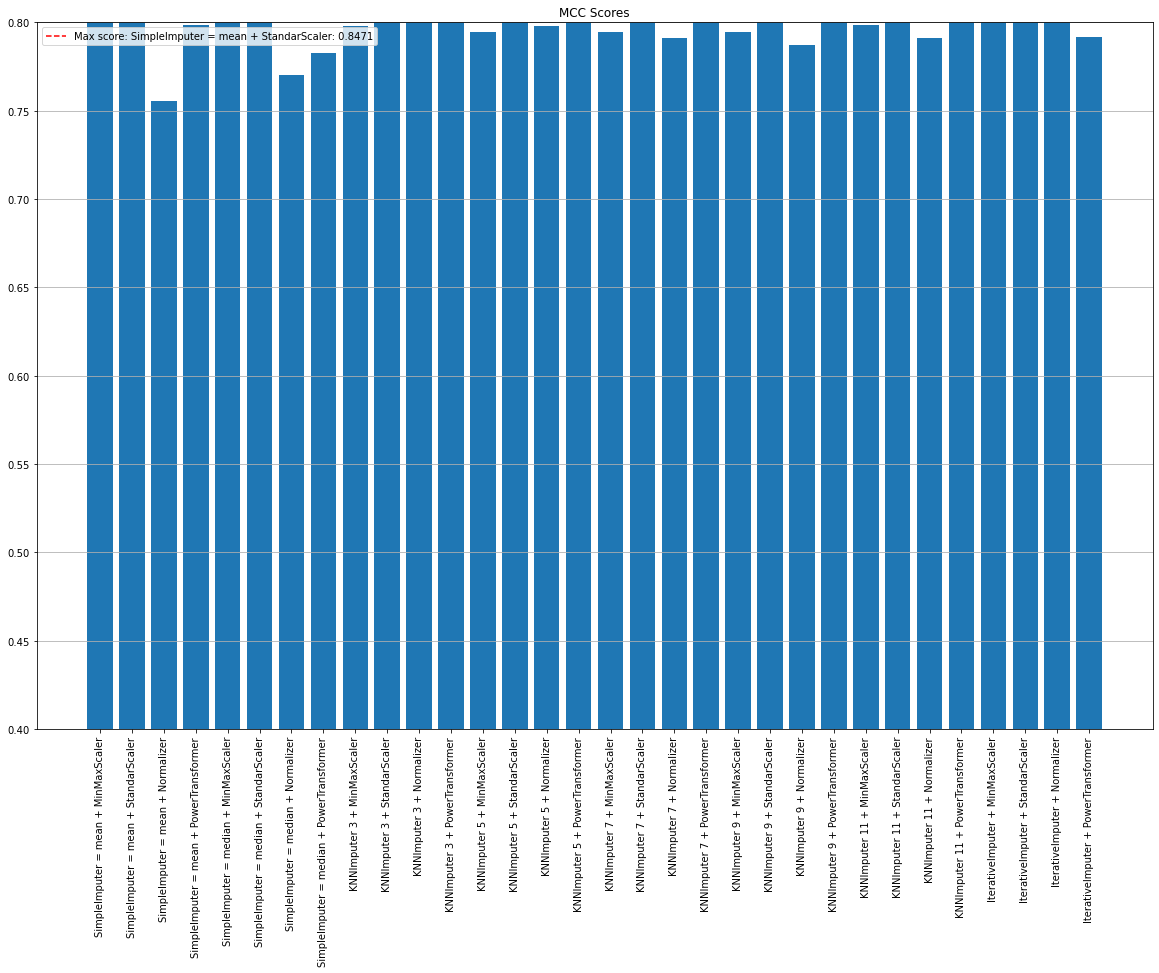

In [155]:
# figsize to adjust size 
fig, ax = plt.subplots(figsize=(20, 13))
ax.bar(combos, scores)
ax.set_title('MCC Scores')

# Set boundries for y axis 
ax.set_ylim([0.4, 0.8])
ax.grid(axis='y')

# Make labels visible
ax.set_xticklabels(combos, rotation=90, ha='center')

# Calculate and show line of max score
max_score_idx = np.argmax(scores)
highest_name, highest_score = combos[max_score_idx], scores[max_score_idx]
ax.axhline(y=scores[max_score_idx], color='r', linestyle='--', label='Max score')

ax.legend([f'Max score: {highest_name}: {highest_score:.4f}'])

plt.show()


## Feature Selection

***
### Prepare dataset using best Imputer and Scaler
 

In [156]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)



***
### Pearson Correlation between each feature and target classification

In [157]:
# Feature selection using Pearson correlation
corr_coef = np.corrcoef(np.hstack((y_train.reshape((-1, 1)), X_train_scaled)).T)
corr_features_idx = np.where(corr_coef[0, 1:] > 0)[0]
X_train_corr = X_train_scaled[:, corr_features_idx]
X_test_corr = X_test_scaled[:, corr_features_idx]

len(corr_features_idx)

8

***
### PCA

PC0 - Variance explained:  0.1824 - Total Variance:  0.1824
PC1 - Variance explained:  0.1177 - Total Variance:  0.3001
PC2 - Variance explained:  0.0991 - Total Variance:  0.3992
PC3 - Variance explained:  0.0795 - Total Variance:  0.4787
PC4 - Variance explained:  0.0689 - Total Variance:  0.5476
PC5 - Variance explained:  0.0506 - Total Variance:  0.5981
PC6 - Variance explained:  0.0359 - Total Variance:  0.6340
PC7 - Variance explained:  0.0331 - Total Variance:  0.6672
PC8 - Variance explained:  0.0299 - Total Variance:  0.6970
PC9 - Variance explained:  0.0284 - Total Variance:  0.7254
PC10 - Variance explained:  0.0265 - Total Variance:  0.7519
PC11 - Variance explained:  0.0255 - Total Variance:  0.7774
PC12 - Variance explained:  0.0234 - Total Variance:  0.8008
PC13 - Variance explained:  0.0221 - Total Variance:  0.8229
PC14 - Variance explained:  0.0202 - Total Variance:  0.8431
PC15 - Variance explained:  0.0168 - Total Variance:  0.8599
PC16 - Variance explained:  0.0154

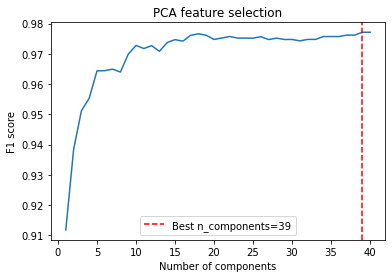

In [158]:


# Feature selection using PCA
pca = PCA(n_components=41)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

tve=0 #total variance explained
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )


# Define the range of number of components to test
n_components_range = range(1, 41)

# Evaluate the models using KNeighbors Classifier
KNCf = KNeighborsClassifier(n_neighbors=3, weights="distance")
f1_scores = []
for n_components in n_components_range:
    # Feature selection using PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    KNCf.fit(X_train_pca, y_train)
    y_pred = KNCf.predict(X_test_pca)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
# Find the best value of n_components based on F1 score
best_n_components = n_components_range[np.argmax(f1_scores)]

# Plot the results
plt.plot(n_components_range, f1_scores)
plt.xlabel('Number of components')
plt.ylabel('F1 score')
plt.title('PCA feature selection')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()


# Feature selection using PCA with optimal value of components
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Number of features to select
n_best = best_n_components

***
### SelectKBest

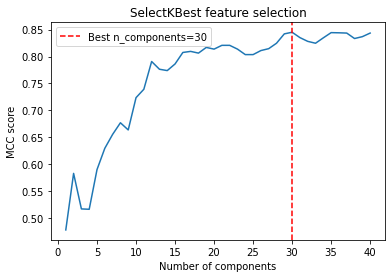

In [159]:
# Feature selection using SelectKBest 

# Define the range of number of components to test
n_components_range = range(1, 41)

# Evaluate the models using Kneighbors Classifier
KNCf = KNeighborsClassifier(n_neighbors=3, weights="distance")
mcc_scores = []
for n_components in n_components_range:
    # Feature selection using PCA
    kbest = SelectKBest(f_classif, k=n_components)
    kbest.fit(X_train_scaled, y_train)
    X_train_kbest = kbest.transform(X_train_scaled)
    X_test_kbest = kbest.transform(X_test_scaled)

    KNCf.fit(X_train_kbest, y_train)
    y_pred = KNCf.predict(X_test_kbest)
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    
# Find the best value of n_components based on F1 score
best_n_components = n_components_range[np.argmax(mcc_scores)]

# Plot the results
plt.plot(n_components_range, mcc_scores)
plt.xlabel('Number of components')
plt.ylabel('MCC score')
plt.title('SelectKBest feature selection')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()

kbest = SelectKBest(f_classif, k=best_n_components)
kbest.fit(X_train_scaled, y_train)
X_train_kbest = kbest.transform(X_train_scaled)
X_test_kbest = kbest.transform(X_test_scaled)

***
### SequentialFeatureSelection

#### Backward

In [160]:
""" from sklearn.feature_selection import SequentialFeatureSelector

# Feature selection using Sequential Feature Selector
scorer = make_scorer(matthews_corrcoef)
sfs_back = SequentialFeatureSelector(LogisticRegression(random_state=42, max_iter=10000),
                                n_features_to_select='auto',
                                direction='backward',
                                scoring=scorer,
                                cv=5)

sfs_back.fit(X_train_scaled, y_train)
X_train_sfs = sfs_back.transform(X_train_scaled)
X_test_sfs = sfs_back.transform(X_test_scaled) """



" from sklearn.feature_selection import SequentialFeatureSelector\n\n# Feature selection using Sequential Feature Selector\nscorer = make_scorer(matthews_corrcoef)\nsfs_back = SequentialFeatureSelector(LogisticRegression(random_state=42, max_iter=10000),\n                                n_features_to_select='auto',\n                                direction='backward',\n                                scoring=scorer,\n                                cv=5)\n\nsfs_back.fit(X_train_scaled, y_train)\nX_train_sfs = sfs_back.transform(X_train_scaled)\nX_test_sfs = sfs_back.transform(X_test_scaled) "

#### Forward


In [161]:

# Define a range of the number of features to consider
n_features_range = [10, 15, 20, 25, 30, 35, 40]
# Create an empty list to store the average cross-validation scores
mcc_scores = []
scorer = make_scorer(matthews_corrcoef)

clf = KNeighborsClassifier(n_neighbors=3, weights="distance")

# Iterate over the number of features and perform cross-validation for each number of features
for n_features in n_features_range:
    sfs = SequentialFeatureSelector(clf, n_features_to_select=n_features, scoring=scorer)
    sfs.fit(X_train_scaled, y_train)
    X_train_sfs = sfs.transform(X_train_scaled)
    X_test_sfs = sfs.transform(X_test_scaled)
    clf.fit(X_train_sfs, y_train)
    y_pred_sfs = clf.predict(X_test_sfs)
    mcc = matthews_corrcoef(y_pred_sfs, y_test)
    print(mcc)
    mcc_scores.append(mcc)
    

# Find the best value of n_components based on F1 score
best_n_components = n_features_range[np.argmax(mcc_scores)]

# Plot the average cross-validation scores against the number of features
plt.plot(n_features_range, mcc_scores)
plt.xlabel('Number of Features')
plt.ylabel('Average  MCC Score')
plt.title('Optimal Number of Features')
plt.axvline(best_n_components, linestyle='--', color='r', label=f'Best n_components={best_n_components}')
plt.legend()
plt.show()



0.8278030984612742
0.8265310361218247
0.8233026813902579
0.807125533336399
0.8372125969493731


In [ ]:
#Optimal number of features is 
sfs = SequentialFeatureSelector(clf, n_features_to_select=25, scoring=scorer)
sfs.fit(X_train_scaled, y_train)
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)

***
### Putting it all together


In [ ]:
# Evaluate the models using Kneighbors Classifier
KNCf = KNeighborsClassifier(n_neighbors=3, weights="distance")
models = [("Pearson", X_train_corr, X_test_corr),
          ("PCA", X_train_pca, X_test_pca),
          ("SelectKBest", X_train_kbest, X_test_kbest),
          ("SequentialFeatureSelection", X_train_sfs, X_test_sfs)]

print(f'{n_best} features')
for name, X_train_fs, X_test_fs in models:
    KNCf.fit(X_train_fs, y_train)
    y_pred = KNCf.predict(X_test_fs)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"{name} with: MCC score = {mcc:.4f}")

25 features
Pearson with: MCC score = 0.6038
PCA with: MCC score = 0.8444
SelectKBest with: MCC score = 0.8539
SequentialFeatureSelection with: MCC score = 0.8341


***
### Now onto selecting the best model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector

# Best Imputer, Scaler and Selector 
imputer = IterativeImputer(random_state=42)
scaler = StandardScaler()
selector = SequentialFeatureSelector(clf, n_features_to_select=35, scoring=scorer)

# Impute missing values
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Feature selection using SelectKBest with F-test
selector.fit(X_train_scaled, y_train)
X_train_kbest = selector.transform(X_train_scaled)
X_test_kbest = selector.transform(X_test_scaled)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

# Define grid of hyperparameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Perform grid search with cross-validation
scorer = make_scorer(matthews_corrcoef)
cv = GridSearchCV(dtc, param_grid=param_grid, scoring=scorer, cv=5)
cv.fit(X_train_kbest, y_train)

# Print the best hyperparameters and performance score
print("Best hyperparameters:", cv.best_params_)
print("Best F1 score:", cv.best_score_)

# Evaluate the model with best hyperparameters on the test set
y_pred = cv.predict(X_test_kbest)

# Check classification scores
print('\n')
classification_scores(y_test, y_pred)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best F1 score: 0.8219039291335696


              precision    recall  f1-score   support

          RB       0.83      0.77      0.80       189
         NRB       0.96      0.97      0.96      1016

    accuracy                           0.94      1205
   macro avg       0.90      0.87      0.88      1205
weighted avg       0.94      0.94      0.94      1205

The Matthews correlation coefficient is:  0.7642
Confusion matrix:
 [[145  44]
 [ 29 987]]


In [ ]:
from sklearn.metrics import classification_report

# create a Random Forest classifier object
rfc = RandomForestClassifier(random_state=42)

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create a GridSearchCV object
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring=scorer)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train_kbest, y_train)

# print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
classification_scores(y_test, y_pred)

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

          RB       0.93      0.81      0.87       189
         NRB       0.97      0.99      0.98      1016

    accuracy                           0.96      1205
   macro avg       0.95      0.90      0.92      1205
weighted avg       0.96      0.96      0.96      1205

The Matthews correlation coefficient is:  0.8505
Confusion matrix:
 [[ 154   35]
 [  11 1005]]


In [ ]:
# Create a SVC classifier
svc = SVC(random_state=42)

# define the parameter grid to search over
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
Cs = [0.01, 0.1, 1, 10, 100, 1000, 10000]
param_grid = {"gamma": gammas, "C": Cs}

# fit the GridSearchCV object to the training data
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring=scorer)
grid_search = grid_search.fit(X_train_kbest, y_train)

# print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
classification_scores(y_test, y_pred)

Best hyperparameters: {'C': 1, 'gamma': 0.1}
              precision    recall  f1-score   support

          RB       0.94      0.85      0.89       189
         NRB       0.97      0.99      0.98      1016

    accuracy                           0.97      1205
   macro avg       0.95      0.92      0.93      1205
weighted avg       0.97      0.97      0.97      1205

The Matthews correlation coefficient is:  0.8709
Confusion matrix:
 [[ 160   29]
 [  11 1005]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#Create a KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_kbest, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_kbest)

# Check classification scores
classification_scores(y_test, y_pred)

Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
              precision    recall  f1-score   support

          RB       0.91      0.81      0.86       189
         NRB       0.97      0.99      0.98      1016

    accuracy                           0.96      1205
   macro avg       0.94      0.90      0.92      1205
weighted avg       0.96      0.96      0.96      1205

The Matthews correlation coefficient is:  0.8344
Confusion matrix:
 [[ 153   36]
 [  15 1001]]


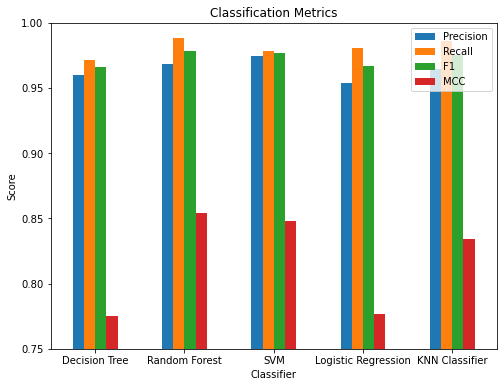

The best classifier is Random Forest, with the MCC score of 0.85416


In [ ]:

# define classifiers
classifiers = [('Decision Tree', DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4, min_samples_split=2, random_state=42)),
               ('Random Forest', RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=42)),
               ('SVM', SVC(C=100, gamma=0.1, random_state=42)),
               ('Logistic Regression', LogisticRegression(random_state=42)),
               ('KNN Classifier', KNeighborsClassifier(n_neighbors=3, weights='distance'))]

# evaluate classifiers using precision, recall, f1, and MCC metrics
metrics = ['Precision', 'Recall', 'F1', 'MCC']
results = pd.DataFrame(columns=metrics, index=[name for name, clf in classifiers])

for name, clf in classifiers:
    clf.fit(X_train_kbest, y_train)
    y_pred = clf.predict(X_test_kbest)
    results.loc[name, 'Precision'] = precision_score(y_test, y_pred)
    results.loc[name, 'Recall'] = recall_score(y_test, y_pred)
    results.loc[name, 'F1'] = f1_score(y_test, y_pred)
    results.loc[name, 'MCC'] = matthews_corrcoef(y_test, y_pred)

# plot results
fig, ax = plt.subplots(figsize=(8, 6))
results.plot(kind='bar', ax=ax)
ax.set_ylim([0.75, 1.0])
ax.set_xlabel('Classifier')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics')
plt.xticks(rotation=0)
plt.show()

# print best classifier and its F1 score
results['MCC'] = results['MCC'].astype(float)
best_classifier = results['MCC'].idxmax()
best_score = results.loc[best_classifier, 'MCC']
print(f'The best classifier is {best_classifier}, with the MCC score of {best_score:.5f}')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
# Create the pipeline
pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler()),
    ('feature_selector', SequentialFeatureSelector(clf, n_features_to_select=30, scoring=scorer)),
    ('classifier', SVC(C=100, gamma=0.1, random_state=42))
])

# Perform cross-validation and make predictions
#y_pred = cross_val_predict(pipeline, X_final, y_final, cv=5)


pipeline.fit(X_search, y_search)
y_pred_final = pipeline.predict(X_final)
# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(y_final, y_pred_final)
print("Matthews Correlation Coefficient:", mcc)

# Display classification report
report = classification_report(y_final, y_pred_final, target_names=['RB', 'NRB'])
print("Classification Report:")
print(report)

Matthews Correlation Coefficient: 0.8493499957736753
Classification Report:
              precision    recall  f1-score   support

          RB       0.89      0.86      0.87       153
         NRB       0.97      0.98      0.98       760

    accuracy                           0.96       913
   macro avg       0.93      0.92      0.92       913
weighted avg       0.96      0.96      0.96       913



In [ ]:
# Define the parameter grid for hyperparameter search
param_grid = {
    'imputer__n_nearest_features': [10, 15, 20, 25, 30, 35],  # Example hyperparameter for IterativeImputer
    'classifier__C': [0.1, 1, 10, 100, 1000],  # Example hyperparameter for SVC
    'classifier__gamma': [0.01, 0.1, 1, 10]  # Example hyperparameter for SVC
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
grid_search.fit(X_search, y_search)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_final)
mcc_score = matthews_corrcoef(y_final, y_pred)

print("Best Hyperparameters:", best_params)
print("Test MCC:", mcc_score)

C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\impute\_iterat

KeyboardInterrupt: 